In [1]:
from lime import lime_tabular
import pickle
import pandas as pd
import pandas_profiling
from gc import collect
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
import lightgbm as lgb
from sklearn.preprocessing import normalize
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
import hdbscan
from graphviz import Source
from IPython.display import SVG
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.feature_selection import RFE

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
%matplotlib inline

In [3]:
df = pd.read_csv('bases_full.csv')

In [4]:
df = df.drop(['Y', 'Estado_Civil_Sexo', 'nPorcentaje_sal_cero_cuo', 'pregunta_2', 'pregunta_28', 'pregunta_8', 'pregunta_25', 'pregunta_23', 'pregunta_29', 'Edad'], axis=1)

In [5]:
dtypes = ['category', 'bool', 'object']
df_categorical = df.loc[:, [col for col in df.columns]].select_dtypes(include=dtypes)
df_categorical.head()
df_categorical.shape
list(df_categorical)

cod_ide                         Cargo cero_cuotas Amonestacion  \
0  C00000001  ASESOR COMERCIAL FUNCIONARIO          si           no   
1  C00000002       ASESOR COMERCIAL MASTER          si           no   
2  C00000003       ASESOR COMERCIAL MASTER          si           no   
3  C00000004  ASESOR COMERCIAL FUNCIONARIO          si           no   
4  C00000005  ASESOR COMERCIAL FUNCIONARIO          no           no   

  nAmonestacion_suspension herencia nProbMoraNoHeredada nProbMoraHeredada  \
0                       no       si               bueno              malo   
1                       no       si                malo              malo   
2                       no       si                malo             bueno   
3                       no       si               bueno              malo   
4                       no       si                malo             bueno   

  Clasificacion_Asesor_Urb_Rur     Genero EstadoCivil nProductividad_dic  \
0                            U  Masculino     Soltero              bueno   
1                            U   Femenino       Otros              bueno   
2                            U   Femenino      Casado              bueno   
3                            U   Femenino     Soltero              bueno   
4                            U   Femenino     Soltero              bueno   

  ingresoef  
0        NO  
1        NO  
2        NO  
3        NO  
4        NO

(768, 13)

['cod_ide',
 'Cargo',
 'cero_cuotas',
 'Amonestacion',
 'nAmonestacion_suspension',
 'herencia',
 'nProbMoraNoHeredada',
 'nProbMoraHeredada',
 'Clasificacion_Asesor_Urb_Rur',
 'Genero',
 'EstadoCivil',
 'nProductividad_dic',
 'ingresoef']

In [6]:
df = pd.get_dummies(df, columns=['Cargo', 'Genero', 'EstadoCivil', 'Clasificacion_Asesor_Urb_Rur'], prefix='D_')

for feature in ['nProbMoraNoHeredada', 'nProbMoraHeredada', 'nProductividad_dic']:
    df.loc[:, feature] = df.loc[:, feature].map({ 'bueno': 1, 'malo': 0 })
    
for feature in ['cero_cuotas', 'Amonestacion', 'nAmonestacion_suspension', 'herencia']:
    df.loc[:, feature] = df.loc[:, feature].map({ 'si': 1, 'no': 0 })
    
df.loc[:, 'ingresoef'] = df.loc[:, 'ingresoef'].map({ 'SI': 1, 'NO': 0 })

df_categorical = df.loc[:, [col for col in list(df) if 
                            col in list(df_categorical) or 
                            col.startswith('D_') or
                            col.startswith('pregunta')]]

for feature in list(df_categorical):
    if feature != 'cod_ide' and not feature.startswith('pregunta'):
        df[feature].value_counts()

1    514
0    254
Name: cero_cuotas, dtype: int64

0    721
1     47
Name: Amonestacion, dtype: int64

0    574
1    194
Name: nAmonestacion_suspension, dtype: int64

1    723
0     45
Name: herencia, dtype: int64

0    417
1    351
Name: nProbMoraNoHeredada, dtype: int64

1    402
0    366
Name: nProbMoraHeredada, dtype: int64

1    731
0     37
Name: nProductividad_dic, dtype: int64

0    584
1    184
Name: ingresoef, dtype: int64

0    707
1     61
Name: D__ASESOR COMERCIAL FUNCIONARIO, dtype: int64

0    611
1    157
Name: D__ASESOR COMERCIAL JUNIOR 1, dtype: int64

0    528
1    240
Name: D__ASESOR COMERCIAL JUNIOR 2, dtype: int64

0    637
1    131
Name: D__ASESOR COMERCIAL MASTER, dtype: int64

0    589
1    179
Name: D__ASESOR COMERCIAL SENIOR, dtype: int64

0    530
1    238
Name: D__Femenino, dtype: int64

1    530
0    238
Name: D__Masculino, dtype: int64

0    621
1    147
Name: D__Casado, dtype: int64

0    676
1     92
Name: D__Otros, dtype: int64

1    529
0    239
Name: D__Soltero, dtype: int64

0    607
1    161
Name: D__R, dtype: int64

1    607
0    161
Name: D__U, dtype: int64

In [7]:
dtypes = ['number']
df_numeric = df.loc[:, [col for col in df.columns if col not in df_categorical.columns]].select_dtypes(include=dtypes)
df_numeric.head()
df_numeric.shape
list(df_numeric)

nEntidades_competencia  nDesem_ult_semana  nPorcentaje_cero_cuotas_ope  \
0                       1           0.256354                     0.000000   
1                       0           0.406922                     0.001969   
2                       5           0.321911                     0.000000   
3                       3           0.294114                     0.008791   
4                       2           0.315331                     0.000000   

   nvarsaldocapital  nporcentaje_Herencia  nOperaciones  nRatio_crec_deuda  \
0          0.013561              0.380552            20           0.880677   
1          0.042866              0.444054            24           2.061512   
2         -0.005801              0.020612            22           0.668892   
3          0.018111              0.300313            26           0.722767   
4          0.004865              0.151475            26           0.000000   

   nProductividad  antiguedad  
0        0.823077         116  
1        0.750000          16  
2        0.827303         140  
3        1.100000          10  
4        0.906250         119

(768, 9)

['nEntidades_competencia',
 'nDesem_ult_semana',
 'nPorcentaje_cero_cuotas_ope',
 'nvarsaldocapital',
 'nporcentaje_Herencia',
 'nOperaciones',
 'nRatio_crec_deuda',
 'nProductividad',
 'antiguedad']

In [8]:
df_discrete = df.loc[:, [col for col in df_numeric.columns if (df[col].dropna() - df[col].dropna().astype(int) == 0).all()]]
df_discrete.head()
df_discrete.shape
list(df_discrete)

nEntidades_competencia  nOperaciones  antiguedad
0                       1            20         116
1                       0            24          16
2                       5            22         140
3                       3            26          10
4                       2            26         119

(768, 3)

['nEntidades_competencia', 'nOperaciones', 'antiguedad']

In [9]:
df_continuous = df.loc[:, [col for col in df_numeric.columns if col not in df_discrete]]
df_continuous.head()
df_continuous.shape
list(df_continuous)

nDesem_ult_semana  nPorcentaje_cero_cuotas_ope  nvarsaldocapital  \
0           0.256354                     0.000000          0.013561   
1           0.406922                     0.001969          0.042866   
2           0.321911                     0.000000         -0.005801   
3           0.294114                     0.008791          0.018111   
4           0.315331                     0.000000          0.004865   

   nporcentaje_Herencia  nRatio_crec_deuda  nProductividad  
0              0.380552           0.880677        0.823077  
1              0.444054           2.061512        0.750000  
2              0.020612           0.668892        0.827303  
3              0.300313           0.722767        1.100000  
4              0.151475           0.000000        0.906250

(768, 6)

['nDesem_ult_semana',
 'nPorcentaje_cero_cuotas_ope',
 'nvarsaldocapital',
 'nporcentaje_Herencia',
 'nRatio_crec_deuda',
 'nProductividad']

## Correlations

In [10]:
df['PM'] = df['nProbMoraHeredada'] + df['nProbMoraNoHeredada']

# Creating target

In [11]:
df['PM'].value_counts()

1    455
0    164
2    149
Name: PM, dtype: int64

In [12]:
def convert_score(el):
    return 1/(el + 1)

In [13]:
df.loc[:, 'PM'] = df.loc[:, 'PM'].apply(convert_score)

In [14]:
df['PM'].value_counts()

0.500000    455
1.000000    164
0.333333    149
Name: PM, dtype: int64

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


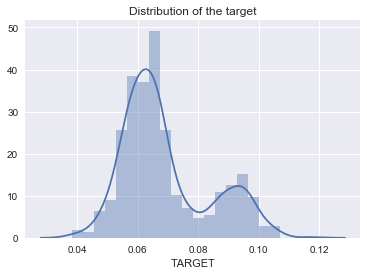

In [15]:
df['N_nProductividad'] = normalize(df['nProductividad'])[0]
df['N_PM'] = normalize(df['PM'])[0]
df['TARGET'] = df['N_nProductividad'] + df['N_PM']
g = sns.distplot(df['TARGET'])
g.set_title('Distribution of the target')

In [16]:
df = df.drop(['PM', 'N_nProductividad', 'N_PM', 'nProductividad', 'nProbMoraHeredada', 'nProbMoraNoHeredada'], axis=1)

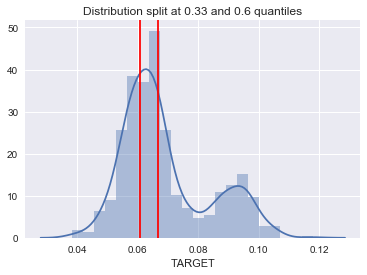

In [17]:
margin1 = 0.33
margin2 = 0.60

g = sns.distplot(df['TARGET'])
g.set_title('Distribution split at {} and {} quantiles'.format(margin1, margin2))
sns.plt.axvline(df['TARGET'].quantile(margin1), color='r')
sns.plt.axvline(df['TARGET'].quantile(margin2), color='r')

plt.show()

In [18]:
df[['cod_ide', 'TARGET']].head()

cod_ide    TARGET
0  C00000001  0.059532
1  C00000002  0.085980
2  C00000003  0.059688
3  C00000004  0.069756
4  C00000005  0.062603

In [19]:
categories = ['bad', 'normal', 'good']
cuts = [min(df['TARGET']), df['TARGET'].quantile(margin1), df['TARGET'].quantile(margin2), max(df['TARGET'])]
df['TARGET'] = pd.cut(df['TARGET'], cuts, labels=categories, include_lowest=True)

In [20]:
df[['cod_ide', 'TARGET']].head()

cod_ide  TARGET
0  C00000001     bad
1  C00000002    good
2  C00000003     bad
3  C00000004    good
4  C00000005  normal

In [21]:
df.loc[:, 'TARGET'] = df.loc[:, 'TARGET'].map({
    'bad': 0,
    'normal': 1,
    'good': 2
})
df['TARGET'].value_counts()

2    307
0    258
1    203
Name: TARGET, dtype: int64

In [22]:
df = df.drop(['cod_ide'], axis=1)

In [23]:
y = df['TARGET']
X = df.drop('TARGET', axis=1)

In [24]:
X.shape, y.shape

((768, 50), (768,))

# Clustering

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
    prediction_data=False)

nEntidades_competencia  nDesem_ult_semana  cero_cuotas  \
0                       1           0.256354            1   
1                       0           0.406922            1   
2                       5           0.321911            1   
3                       3           0.294114            1   
4                       2           0.315331            0   

   nPorcentaje_cero_cuotas_ope  Amonestacion  nAmonestacion_suspension  \
0                     0.000000             0                         0   
1                     0.001969             0                         0   
2                     0.000000             0                         0   
3                     0.008791             0                         0   
4                     0.000000             0                         0   

   nvarsaldocapital  herencia  nporcentaje_Herencia  nOperaciones   ...     \
0          0.013561         1              0.380552            20   ...      
1          0.042866         1              0.444054            24   ...      
2         -0.005801         1              0.020612            22   ...      
3          0.018111         1              0.300313            26   ...      
4          0.004865         1              0.151475            26   ...      

   D__ASESOR COMERCIAL MASTER  D__ASESOR COMERCIAL SENIOR  D__Femenino  \
0                           0                           0            0   
1                           1                           0            1   
2                           1                           0            1   
3                           0                           0            1   
4                           0                           0            1   

   D__Masculino  D__Casado  D__Otros  D__Soltero  D__R  D__U  cluster  
0             1          0         0           1     0     1       -1  
1             0          0         1           0     0     1        1  
2             0          1         0           0     0     1       -1  
3             0          0         0           1     0     1        1  
4             0          0         0           1     0     1        0  

[5 rows x 51 columns]

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=777, splitter='best')

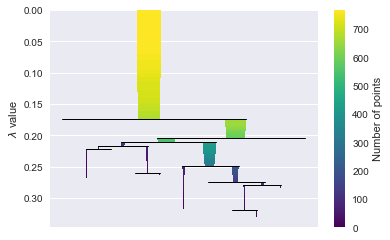

In [25]:
clusterer = hdbscan.HDBSCAN(gen_min_span_tree=True)
clusterer.fit(X)
plt.figure()
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      edge_linewidth=1)
plt.figure()
clusterer.condensed_tree_.plot(selection_palette=sns.color_palette())



palette = sns.color_palette()
cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]
X['cluster'] = pd.Series(clusterer.labels_)
X.head()
y_cluster = X['cluster']
X_cluster = X.drop('cluster', axis=1)

cluster_names = list(range(1, len(X['cluster'].value_counts()) + 1))

dtc = DecisionTreeClassifier(random_state=777, max_depth=4, criterion='entropy')
dtc.fit(X_cluster, y_cluster)

graph = Source(export_graphviz(dtc, out_file=None, feature_names=X_cluster.columns, filled=True, class_names=list(map(str, cluster_names))))

SVG(graph.pipe(format='svg'))

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
    prediction_data=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


nEntidades_competencia  nDesem_ult_semana  cero_cuotas  \
1                        0           0.406922            1   
3                        3           0.294114            1   
6                        0           0.075777            1   
12                       6           0.494248            0   
13                       0           0.229230            1   

    nPorcentaje_cero_cuotas_ope  Amonestacion  nAmonestacion_suspension  \
1                      0.001969             0                         0   
3                      0.008791             0                         0   
6                      0.010038             0                         0   
12                     0.000000             0                         0   
13                     0.000000             0                         0   

    nvarsaldocapital  herencia  nporcentaje_Herencia  nOperaciones   ...    \
1           0.042866         1              0.444054            24   ...     
3           0.018111         1              0.300313            26   ...     
6          -0.000645         1              0.067877            18   ...     
12          0.008872         1              0.283106            21   ...     
13         -0.033884         1              0.368710            25   ...     

    D__ASESOR COMERCIAL MASTER  D__ASESOR COMERCIAL SENIOR  D__Femenino  \
1                            1                           0            1   
3                            0                           0            1   
6                            0                           0            1   
12                           1                           0            1   
13                           1                           0            1   

    D__Masculino  D__Casado  D__Otros  D__Soltero  D__R  D__U  TARGET  
1              0          0         1           0     0     1       2  
3              0          0         0           1     0     1       2  
6              0          1         0           0     0     1       2  
12             0          1         0           0     0     1       2  
13             0          0         0           1     0     1       2  

[5 rows x 51 columns]

1     4.0
3    -1.0
6     1.0
12   -1.0
13   -1.0
Name: cluster, dtype: float64

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=777, splitter='best')

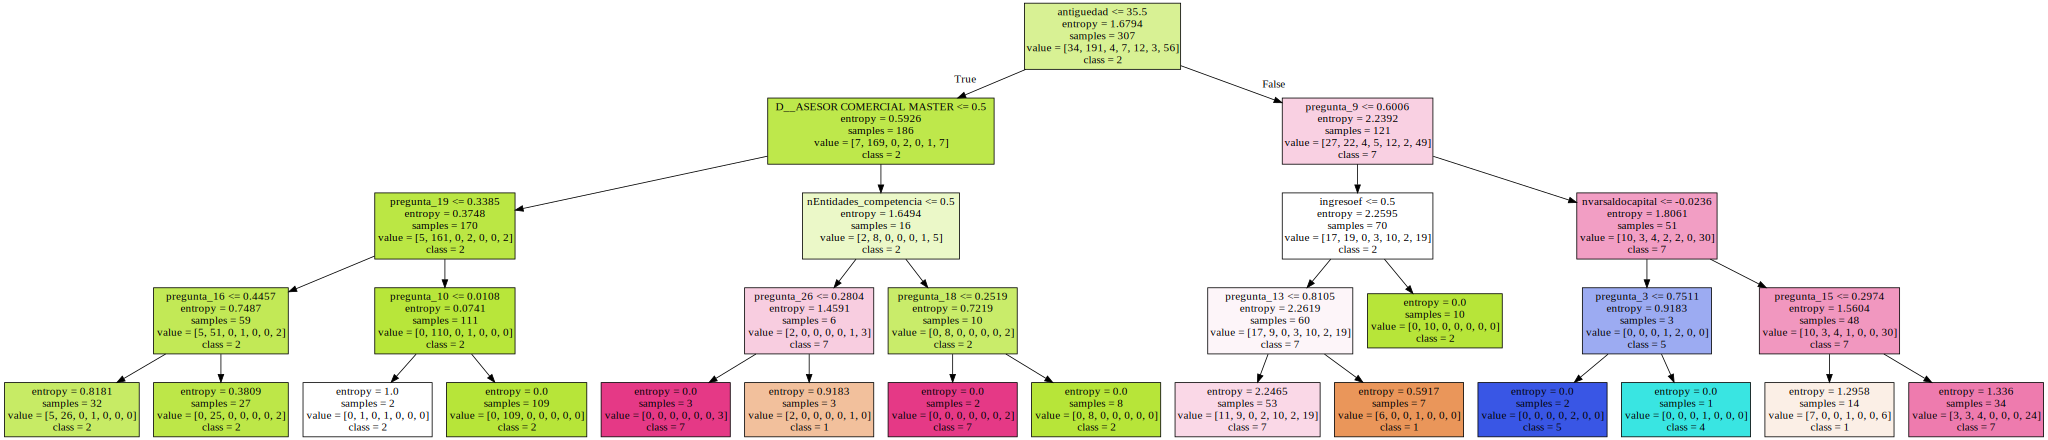

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
    prediction_data=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


nEntidades_competencia  nDesem_ult_semana  cero_cuotas  \
0                        1           0.256354            1   
2                        5           0.321911            1   
8                        0           0.362352            1   
9                        2           0.221844            0   
11                       0           0.397763            1   

    nPorcentaje_cero_cuotas_ope  Amonestacion  nAmonestacion_suspension  \
0                      0.000000             0                         0   
2                      0.000000             0                         0   
8                      0.016685             1                         1   
9                      0.000000             0                         0   
11                     0.003868             0                         0   

    nvarsaldocapital  herencia  nporcentaje_Herencia  nOperaciones   ...    \
0           0.013561         1              0.380552            20   ...     
2          -0.005801         1              0.020612            22   ...     
8           0.031143         0              0.000000            16   ...     
9           0.008442         1              0.049933            23   ...     
11          0.008172         0              0.000000            27   ...     

    D__ASESOR COMERCIAL MASTER  D__ASESOR COMERCIAL SENIOR  D__Femenino  \
0                            0                           0            0   
2                            1                           0            1   
8                            0                           0            0   
9                            0                           1            0   
11                           1                           0            1   

    D__Masculino  D__Casado  D__Otros  D__Soltero  D__R  D__U  TARGET  
0              1          0         0           1     0     1       0  
2              0          1         0           0     0     1       0  
8              1          0         1           0     0     1       0  
9              1          0         0           1     0     1       0  
11             0          1         0           0     0     1       0  

[5 rows x 51 columns]

0    -1.0
2    -1.0
8     0.0
9     0.0
11    0.0
Name: cluster, dtype: float64

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=777, splitter='best')

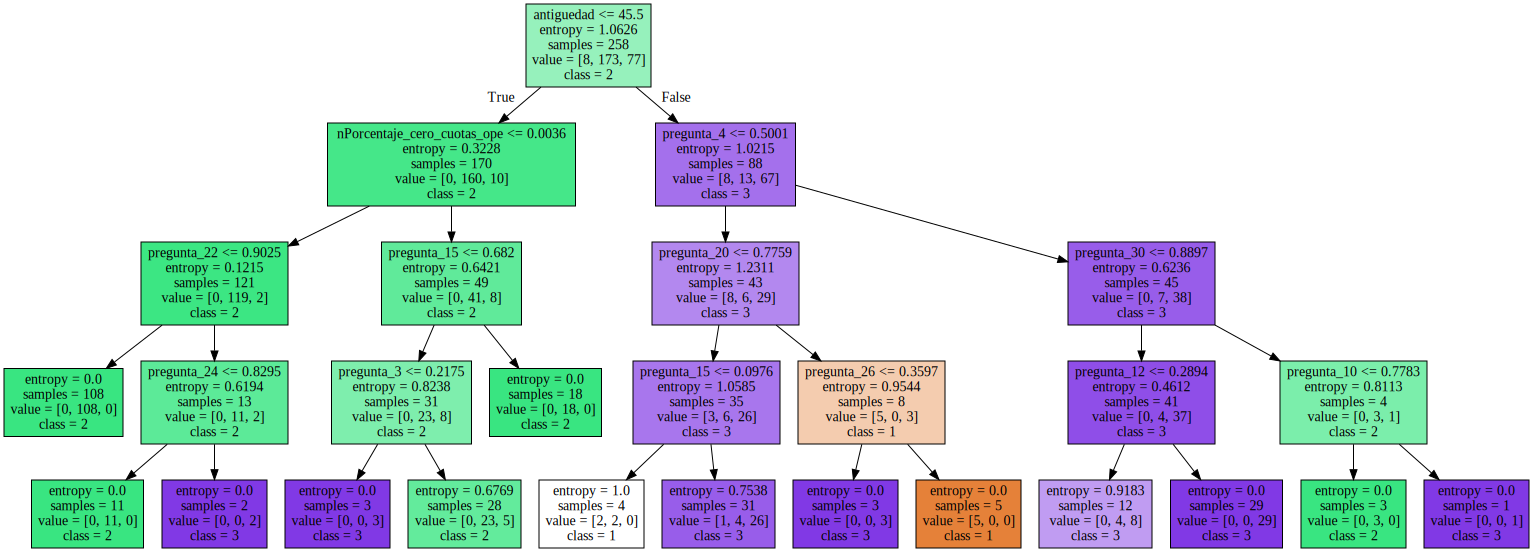

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=True, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
    prediction_data=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


nEntidades_competencia  nDesem_ult_semana  cero_cuotas  \
4                        2           0.315331            0   
5                        5           0.351645            1   
7                        0           0.461129            0   
10                       1           0.284317            0   
15                       4           0.263154            1   

    nPorcentaje_cero_cuotas_ope  Amonestacion  nAmonestacion_suspension  \
4                      0.000000             0                         0   
5                      0.004474             0                         0   
7                      0.000000             0                         0   
10                     0.000000             0                         0   
15                     0.000000             0                         0   

    nvarsaldocapital  herencia  nporcentaje_Herencia  nOperaciones   ...    \
4           0.004865         1              0.151475            26   ...     
5           0.019909         1              0.402010            21   ...     
7          -0.009965         1              0.065337            29   ...     
10         -0.009481         1              0.103537            19   ...     
15          0.022777         1              0.253971            25   ...     

    D__ASESOR COMERCIAL MASTER  D__ASESOR COMERCIAL SENIOR  D__Femenino  \
4                            0                           0            1   
5                            1                           0            1   
7                            0                           0            0   
10                           0                           0            1   
15                           0                           1            0   

    D__Masculino  D__Casado  D__Otros  D__Soltero  D__R  D__U  TARGET  
4              0          0         0           1     0     1       1  
5              0          0         0           1     0     1       1  
7              1          0         0           1     0     1       1  
10             0          0         0           1     0     1       1  
15             1          0         0           1     0     1       1  

[5 rows x 51 columns]

4     3.0
5    -1.0
7    -1.0
10   -1.0
15   -1.0
Name: cluster, dtype: float64

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=777, splitter='best')

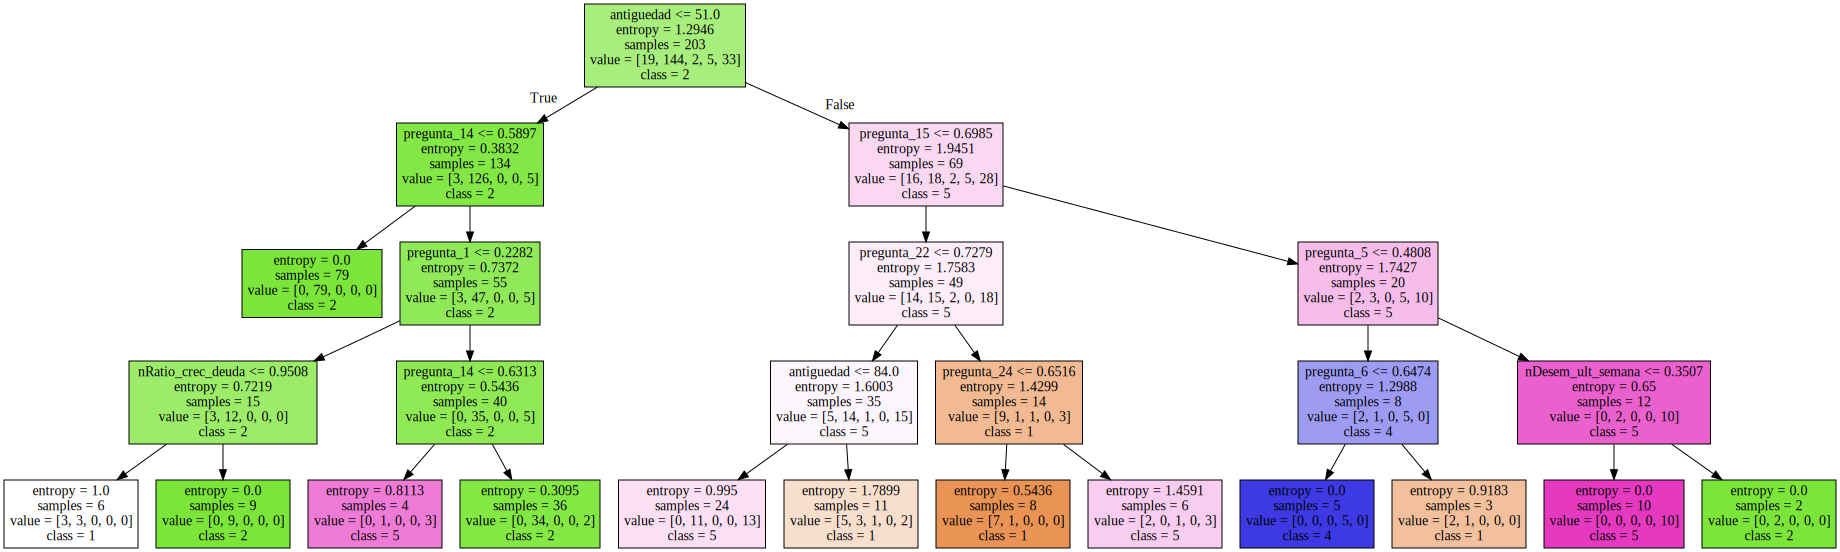

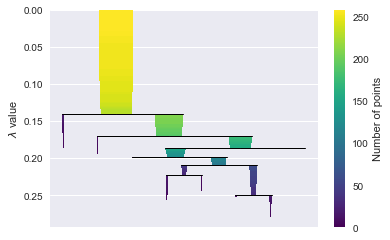

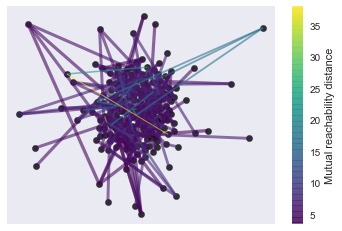

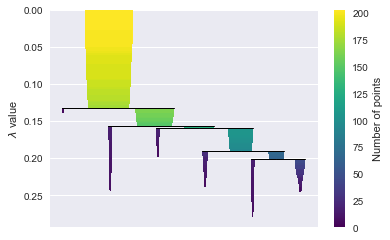

In [26]:
for target_class in list(y.value_counts().index):
    X_target = df.loc[df['TARGET'] == target_class]
    clusterer = hdbscan.HDBSCAN(gen_min_span_tree=True)
    clusterer.fit(X_target)
    plt.figure()
    clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                          edge_alpha=0.6,
                                          edge_linewidth=1)
    plt.figure()
    clusterer.condensed_tree_.plot(selection_palette=sns.color_palette())
    palette = sns.color_palette()
    cluster_colors = [sns.desaturate(palette[col], sat)
                      if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                      zip(clusterer.labels_, clusterer.probabilities_)]
    X_target['cluster'] = pd.Series(clusterer.labels_)
    y_cluster = X_target['cluster']
    X_cluster = X_target.drop('cluster', axis=1)
    
    X_cluster.head()
    y_cluster.head()
    
    cluster_names = list(range(1, len(X_target['cluster'].value_counts()) + 1))

    dtc = DecisionTreeClassifier(random_state=777, max_depth=4, criterion='entropy')
    dtc.fit(X_cluster.fillna(0), y_cluster.fillna(0))

    graph = Source(export_graphviz(dtc, out_file=None, feature_names=X_cluster.columns, filled=True, class_names=list(map(str, cluster_names))))

    SVG(graph.pipe(format='svg'))

In [27]:
X.shape, y.shape

((768, 51), (768,))

# Cross-validation

In [28]:
eval_size = 0.1
kf = StratifiedKFold(df['TARGET'], round(1./eval_size))
train_ix, valid_ix = next(iter(kf))

In [29]:
X_train, y_train = X.iloc[train_ix], y.iloc[train_ix]
X_valid, y_valid = X.iloc[valid_ix], y.iloc[valid_ix]
X_train.shape, y_train.shape
X_valid.shape, y_valid.shape

((690, 51), (690,))

((78, 51), (78,))

In [30]:
def increase_value(feature, temp, value):

    before_value = temp.loc[feature]
    after_value = temp.loc[feature] + value

    before = model.predict(temp)[0]
    temp.loc[feature] += value
    after = model.predict(temp)[0]
    
    if sum(before == after) == 0:  
        print('\nIncreasing {}'.format(feature))
        print('From {} to {}'.format(before_value, after_value))
        print('Before: {} (class {})'.format(before, list(before).index(max(before))))
        print(' After: {} (class {})'.format(after, list(after).index(max(after))))

In [31]:
def decrease_value(feature, temp, value):

    before_value = temp.loc[feature]
    after_value = temp.loc[feature] - value

    before = model.predict(temp)[0]
    temp.loc[feature] -= value
    after = model.predict(temp)[0]
    
    if sum(before == after) == 0:  
        print('\nDecreasing {}'.format(feature))
        print('From {} to {}'.format(before_value, after_value))
        print('Before: {} (class {})'.format(before, list(before).index(max(before))))
        print(' After: {} (class {})'.format(after, list(after).index(max(after))))

# Models

In [32]:
model_results = {
    'lightgbm': {
        'recall': None,
        'precision': None,
        'accuracy': None,
        'fe_entropy': [],
        'fe_rfe': []
    },
    'random_forest': {
        'recall': None,
        'precision': None,
        'accuracy': None,
        'fe_entropy': [],
        'fe_rfe': []
    },
    'extra_trees': {
        'recall': None,
        'precision': None,
        'accuracy': None,
        'fe_entropy': [],
        'fe_rfe': []
    }
}

## LightGBM

In [33]:
d_train = lgb.Dataset(X_train, y_train)
d_valid = lgb.Dataset(X_valid, y_valid, reference=d_train)

In [34]:
estimator = lgb.LGBMClassifier()
param_grid = {
    'learning_rate': [0.01, 0.02, 0.03,0.04, 0.05],
    'num_leaves': [8, 10, 20, 30, 40, 50],
    'boosting_type' : ['gbdt'],
    'objective' : ['multiclass'],
    'metric': ['multi_logloss'],
    'num_class': [3],
    'seed' : [777],
    'colsample_bytree' : [0.6, 0.7,0.8,0.9,1],
    'subsample' : [0.6, 0.7,0.8,0.9,1],
    'reg_alpha' : [0,0.1,0.5,1],
    'reg_lambda' : [0,0.01, 0.05, 0.1, 1,2,5,6,7,9,10],
    'is_unbalance' : [True,False],
}
clf = RandomizedSearchCV(estimator, param_grid, cv=10)
clf.fit(X_train, y_train)
clf.best_params_

y_pred = clf.predict(X_valid)

cm = confusion_matrix(y_valid, y_pred)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Recall: {}'.format(cm[2][2]/sum(cm[2])))
print('Precision: {}'.format(cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])))
print('Accuracy: {}'.format(accuracy_score(y_pred, y_valid)))

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, learning_rate=0.1,
        max_bin=255, max_depth=-1, min_child_samples=10,
        min_child_weight=5, min_split_gain=0, n_estimators=10, nthread=-1,
        num_leaves=31, objective='binary', reg_alpha=0, reg_lambda=0,
        seed=0, silent=True, subsample=1, subsample_for_bin=50000,
        subsample_freq=1),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'learning_rate': [0.01, 0.02, 0.03, 0.04, 0.05], 'num_leaves': [8, 10, 20, 30, 40, 50], 'boosting_type': ['gbdt'], 'objective': ['multiclass'], 'metric': ['multi_logloss'], 'num_class': [3], 'seed': [777], 'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1], 'subsample': [0.6, 0.7, 0.8, 0.9, 1], 'reg_alpha': [0, 0.1, 0.5, 1], 'reg_lambda': [0, 0.01, 0.05, 0.1, 1, 2, 5, 6, 7, 9, 10], 'is_unbalance': [True, False]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.9,
 'is_unbalance': False,
 'learning_rate': 0.04,
 'metric': 'multi_logloss',
 'num_class': 3,
 'num_leaves': 10,
 'objective': 'multiclass',
 'reg_alpha': 0.1,
 'reg_lambda': 2,
 'seed': 777,
 'subsample': 0.8}

Recall: 0.7096774193548387
Precision: 0.55
Accuracy: 0.5384615384615384


[1]	valid_0's multi_logloss: 1.09086
[2]	valid_0's multi_logloss: 1.08447
[3]	valid_0's multi_logloss: 1.07662
[4]	valid_0's multi_logloss: 1.07154
[5]	valid_0's multi_logloss: 1.06637
[6]	valid_0's multi_logloss: 1.064
[7]	valid_0's multi_logloss: 1.05712
[8]	valid_0's multi_logloss: 1.05108
[9]	valid_0's multi_logloss: 1.04587
[10]	valid_0's multi_logloss: 1.04138
[11]	valid_0's multi_logloss: 1.03592
[12]	valid_0's multi_logloss: 1.03032
[13]	valid_0's multi_logloss: 1.0257
[14]	valid_0's multi_logloss: 1.02124
[15]	valid_0's multi_logloss: 1.01718
[16]	valid_0's multi_logloss: 1.01422
[17]	valid_0's multi_logloss: 1.01029
[18]	valid_0's multi_logloss: 1.00769
[19]	valid_0's multi_logloss: 1.00485
[20]	valid_0's multi_logloss: 1.00157
[21]	valid_0's multi_logloss: 0.999977
[22]	valid_0's multi_logloss: 0.996451
[23]	valid_0's multi_logloss: 0.993526
[24]	valid_0's multi_logloss: 0.992349
[25]	valid_0's multi_logloss: 0.989357
[26]	valid_0's multi_logloss: 0.98658
[27]	valid_0's mult

Recall: 0.7419354838709677
Precision: 0.6216216216216216
Accuracy: 0.5897435897435898


Feature importance based on entropy:
Feature ranking with recursive feature elimination:


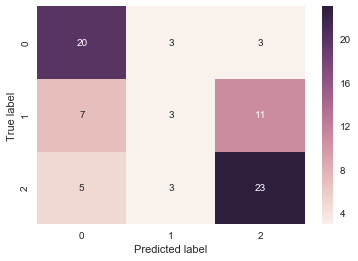

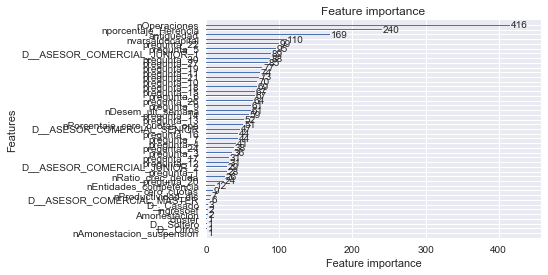

In [35]:
model = lgb.train(clf.best_params_, d_train, 100, valid_sets=d_valid)

y_pred = model.predict(X_valid)

y_pred_trunc = list()
for row in y_pred:
    y_pred_trunc.append(list(row).index(max(row)))
y_pred_trunc = pd.Series(y_pred_trunc)

cm = confusion_matrix(y_valid, y_pred_trunc)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')

recall = cm[2][2]/sum(cm[2])
print('Recall: {}'.format(recall))
model_results['lightgbm']['recall'] = recall

precision = cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])
print('Precision: {}'.format(precision))
model_results['lightgbm']['precision'] = precision

accuracy = accuracy_score(y_pred_trunc, y_valid)
print('Accuracy: {}'.format(accuracy))
model_results['lightgbm']['accuracy'] = accuracy

lgb.plot_importance(model)

print('Feature importance based on entropy:')
d = dict(zip(model.feature_name(), model.feature_importance()))
fe_entropy = sorted(d.items(), key=lambda x: x[1], reverse=True)
model_results['lightgbm']['fe_entropy'] = fe_entropy

print('Feature ranking with recursive feature elimination:')
selector = RFE(estimator, 5, step=1)
selector = selector.fit(X, y)
d = dict(zip(X.columns, selector.ranking_))
fe_rfe = sorted(d.items(), key=lambda x: x[1])
model_results['lightgbm']['fe_rfe'] = fe_rfe

### LIME using LightGBM

In [36]:
explainer = lime_tabular.LimeTabularExplainer(
    X_train, 
    feature_names=list(X_train),
    discretize_continuous=False
    )
i = np.random.randint(0, X_valid.shape[0])
exp = explainer.explain_instance(X_valid.iloc[i], model.predict)
exp.show_in_notebook(show_table=True, show_all=False)
temp = X_valid.iloc[i].copy()
for feature in X_valid.columns:
    increase_value(feature, temp, 10)
    decrease_value(feature, temp, 20)

C:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:423: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')



Decreasing nEntidades_competencia
From 15.0 to -5.0
Before: [ 0.38505352  0.15990493  0.45504155] (class 2)
 After: [ 0.39770562  0.15960085  0.44269353] (class 2)

Decreasing nDesem_ult_semana
From 10.439953044125092 to -9.560046955874908
Before: [ 0.39770562  0.15960085  0.44269353] (class 2)
 After: [ 0.45251953  0.16238703  0.38509343] (class 0)

Decreasing cero_cuotas
From 11.0 to -9.0
Before: [ 0.45251953  0.16238703  0.38509343] (class 0)
 After: [ 0.45643355  0.16393631  0.37963014] (class 0)

Increasing nPorcentaje_cero_cuotas_ope
From 0.0 to 10.0
Before: [ 0.45643355  0.16393631  0.37963014] (class 0)
 After: [ 0.43946467  0.17080884  0.38972649] (class 0)

Decreasing nPorcentaje_cero_cuotas_ope
From 10.0 to -10.0
Before: [ 0.43946467  0.17080884  0.38972649] (class 0)
 After: [ 0.45643355  0.16393631  0.37963014] (class 0)

Increasing Amonestacion
From 0.0 to 10.0
Before: [ 0.45643355  0.16393631  0.37963014] (class 0)
 After: [ 0.45452197  0.16743781  0.37804022] (class 0)

Increasing D__Otros
From 0.0 to 10.0
Before: [ 0.82003666  0.07362995  0.10633339] (class 0)
 After: [ 0.81771043  0.07625782  0.10603175] (class 0)

Decreasing D__Otros
From 10.0 to -10.0
Before: [ 0.81771043  0.07625782  0.10603175] (class 0)
 After: [ 0.82003666  0.07362995  0.10633339] (class 0)


## Random Forest

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=777,
            verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': [120, 300, 500, 800, 1200], 'max_depth': [5, 8, 15, 25, 30, None], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [2, 5, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

{'max_depth': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 800}

Recall: 0.7096774193548387
Precision: 0.55
Accuracy: 0.5384615384615384


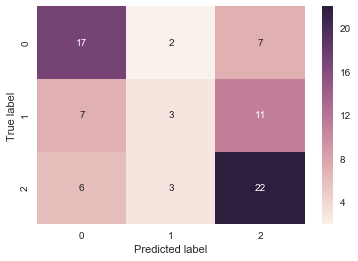

In [37]:
estimator = RandomForestClassifier(random_state=777)
param_grid = {
    'n_estimators': [120, 300, 500, 800, 1200],
    'max_depth': [5, 8, 15, 25, 30, None],
    'min_samples_split': [2, 5, 10, 15, 100],
    'min_samples_leaf': [2, 5, 10]
}
clf = RandomizedSearchCV(estimator, param_grid, cv=10)
clf.fit(X_train, y_train)
clf.best_params_

y_pred = clf.predict(X_valid)

cm = confusion_matrix(y_valid, y_pred)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Recall: {}'.format(cm[2][2]/sum(cm[2])))
print('Precision: {}'.format(cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])))
print('Accuracy: {}'.format(accuracy_score(y_pred, y_valid)))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=800, n_jobs=1, oob_score=False, random_state=777,
            verbose=0, warm_start=False)

Recall: 0.7096774193548387
Precision: 0.55
Accuracy: 0.5384615384615384
Feature importance based on entropy:
Feature ranking with recursive feature elimination:


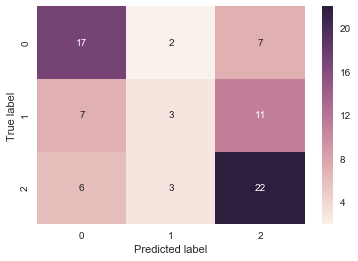

In [38]:
model = RandomForestClassifier(
    max_depth=clf.best_params_['max_depth'],
    min_samples_leaf=clf.best_params_['min_samples_leaf'],
    min_samples_split=clf.best_params_['min_samples_split'],
    n_estimators=clf.best_params_['n_estimators'],
    random_state=777)

model.fit(X_train, y_train)

y_pred = model.predict(X_valid)

cm = confusion_matrix(y_valid, y_pred)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')

recall = cm[2][2]/sum(cm[2])
print('Recall: {}'.format(recall))
model_results['random_forest']['recall'] = recall

precision = cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])
print('Precision: {}'.format(precision))
model_results['random_forest']['precision'] = precision

accuracy = accuracy_score(y_pred, y_valid)
print('Accuracy: {}'.format(accuracy))
model_results['random_forest']['accuracy'] = accuracy

print('Feature importance based on entropy:')
d = dict(zip(list(X_train), model.feature_importances_))
fe_entropy = sorted(d.items(), key=lambda x: x[1], reverse=True)
model_results['random_forest']['fe_entropy'] = fe_entropy

print('Feature ranking with recursive feature elimination:')
selector = RFE(estimator, 5, step=1)
selector = selector.fit(X, y)
d = dict(zip(X.columns, selector.ranking_))
fe_rfe = sorted(d.items(), key=lambda x: x[1])
model_results['random_forest']['fe_rfe'] = fe_rfe

### LIME using Random Forests

In [39]:
explainer = lime_tabular.LimeTabularExplainer(
    X_train, 
    feature_names=list(X_train),
    discretize_continuous=False
    )
i = np.random.randint(0, X_valid.shape[0])
exp = explainer.explain_instance(X_valid.iloc[i], model.predict_proba)
exp.show_in_notebook(show_table=True, show_all=False)

# Extra Trees

In [40]:
estimator = ExtraTreesClassifier(random_state=777)
param_grid = {
    'n_estimators': [120, 300, 500, 800, 1200],
    'min_samples_split': [2, 5, 10, 15, 100],
    'min_samples_leaf': [2, 5, 10]
}
clf = RandomizedSearchCV(estimator, param_grid, cv=10)
clf.fit(X_train, y_train)
clf.best_params_

y_pred = clf.predict(X_valid)

cm = confusion_matrix(y_valid, y_pred)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')

print('Recall: {}'.format(cm[2][2]/sum(cm[2])))
print('Precision: {}'.format(cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])))
print('Accuracy: {}'.format(accuracy_score(y_pred, y_valid)))

RandomizedSearchCV(cv=10, error_score='raise',
          estimator=ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=777,
           verbose=0, warm_start=False),
          fit_params={}, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': [120, 300, 500, 800, 1200], 'min_samples_split': [2, 5, 10, 15, 100], 'min_samples_leaf': [2, 5, 10]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring=None, verbose=0)

{'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}

Recall: 0.6451612903225806
Precision: 0.5128205128205128
Accuracy: 0.46153846153846156


In [41]:
model = ExtraTreesClassifier(
    min_samples_leaf=clf.best_params_['min_samples_leaf'],
    min_samples_split=clf.best_params_['min_samples_split'],
    n_estimators=clf.best_params_['n_estimators'],
    random_state=777)
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)
cm = confusion_matrix(y_valid, y_pred)
g = sns.heatmap(cm, annot=True)
g.yaxis.set_ticklabels(g.yaxis.get_ticklabels())
g.xaxis.set_ticklabels(g.xaxis.get_ticklabels())
plt.ylabel('True label')
plt.xlabel('Predicted label')

recall = cm[2][2]/sum(cm[2])
print('Recall: {}'.format(recall))
model_results['extra_trees']['recall'] = recall

precision = cm[2][2]/(cm[0][2] + cm[1][2] + cm[2][2])
print('Precision: {}'.format(precision))
model_results['extra_trees']['precision'] = precision

accuracy = accuracy_score(y_pred, y_valid)
print('Accuracy: {}'.format(accuracy))
model_results['extra_trees']['accuracy'] = accuracy

print('Feature importance based on entropy:')
d = dict(zip(list(X_train), model.feature_importances_))
fe_entropy = sorted(d.items(), key=lambda x: x[1], reverse=True)
model_results['extra_trees']['fe_entropy'] = fe_entropy

print('Feature ranking with recursive feature elimination:')
selector = RFE(estimator, 5, step=1)
selector = selector.fit(X, y)
d = dict(zip(X.columns, selector.ranking_))
fe_rfe = sorted(d.items(), key=lambda x: x[1])
model_results['extra_trees']['fe_rfe'] = fe_rfe

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=2,
           min_samples_split=10, min_weight_fraction_leaf=0.0,
           n_estimators=300, n_jobs=1, oob_score=False, random_state=777,
           verbose=0, warm_start=False)

Recall: 0.6451612903225806
Precision: 0.5128205128205128
Accuracy: 0.46153846153846156
Feature importance based on entropy:
Feature ranking with recursive feature elimination:


### LIME using Extra Trees

In [42]:
explainer = lime_tabular.LimeTabularExplainer(
    X_train, 
    feature_names=list(X_train),
    discretize_continuous=False
    )
i = np.random.randint(0, X_valid.shape[0])
exp = explainer.explain_instance(X_valid.iloc[i], model.predict_proba)
exp.show_in_notebook(show_table=True, show_all=False)